# 1 - Introduction

This notebook is devoted to the development of the models used to predict wages and preferred positions of FIFA 20 players. Here I try to be as clear as possible about my thoughts on the process (data manipulation, metrics used, feature engineering etc).

## Summary

- [2 - Wage Predictions](#2---Wage-predictions)
    - [2.1 - First model](#2.1---First-model)
    - [2.2 - Dealing with skewness in the target variable](#2.2---Dealing-with-skewness-in-the-target-variable)
    - [2.3 - Feature engineering](#2.3---Feature-engineering)
    - [2.4 - Model tuning](#2.4---Model-tuning)
    - [2.5 - Final model](#2.5---Final-model)
    
    
- [3 - Preferred positions predictions](#3---Preferred-positions-predictions)
    - [3.1 - First model](#3.1---First-model)
    - [3.2 - Feature engineering](#3.2---Feature-engineering)
    - [3.3 - Model tuning and predictions](#3.3---Model-tuning-and-predictions)
    

- [4 - About the application](#4---About-the-application)


- [5 - Getting a response from the Flask API](#5---Getting-a-response-from-the-Flask-API)


- [6 - Building a webapp](#6---Building-a-webapp)

In [1]:
#Importing libraries used in this notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from scipy.special import inv_boxcox

import pickle
import requests

from IPython.display import clear_output

In [2]:
#Data loading and cleaning (explained on fifa_players_analysis.ipynb file).

players_df = pd.read_csv('fifaindex_players.csv')

# Some players have team_club and team_nation values switched due to random differences in FIFA Index page layouts
# This code corrects this issue by using the fact that team_nation must be equal to the nationality of the player
condition = players_df['team_club']==players_df['nationality']
players_df.loc[condition,'team_club'] = players_df[condition]['team_nation']
players_df.loc[condition,'team_nation'] = players_df[condition]['nationality']

# In the scrapper, missing data was assigned to 0, but there are also empty string missing data.
players_df = players_df.replace([0,'0',' '],np.nan)

# Removing strings from numeric features and converting them into int (or float)
players_df['height'] = players_df['height'].apply(lambda x: x.strip(' cm')).astype(int)
players_df['weight'] = players_df['weight'].apply(lambda x: x.strip(' kg')).astype(int)
players_df['value'] = players_df['value'].apply(lambda x: x.strip('€').replace('.','') if (pd.notna(x)) else x).astype(float)
players_df['wage'] = players_df['wage'].apply(lambda x: x.strip('€').replace('.','') if (pd.notna(x)) else x).astype(float)

players_df.head()

,name,overall,potential,nationality,description,height,weight,preferred_foot,birth_date,age,...,curve,fk_acc,penalties,volleys,gk_positioning,gk_diving,gk_handling,gk_kicking,gk_reflexes,specialities_traits
0,Lionel Messi,94,94,Argentina,"Lionel Messi was born on June 24, 1987. He is ...",170,72,Left,"June 24, 1987",33,...,93,94,75,88,14,6,11,15,8,Dribbler/Distance Shooter/Crosser/FK Specialis...
1,Cristiano Ronaldo,93,93,Portugal,"Cristiano Ronaldo was born on Feb. 5, 1985. He...",187,83,Right,"Feb. 5, 1985",35,...,81,76,85,87,14,7,11,15,11,Dribbler/Distance Shooter/Acrobat/Clinical Fin...
2,Neymar Jr,92,92,Brazil,"Neymar Jr was born on Feb. 5, 1992. He is curr...",175,68,Right,"Feb. 5, 1992",28,...,88,89,92,87,15,9,9,15,11,Speedster/Dribbler/Playmaker/Crosser/FK Specia...
3,Virgil van Dijk,91,92,Netherlands,"Virgil van Dijk was born on July 8, 1991. He i...",193,92,Right,"July 8, 1991",29,...,60,70,62,45,11,13,10,13,11,Tackling/Tactician/Strength/Complete Defender/...
4,Jan Oblak,91,93,Slovenia,"Jan Oblak was born on Jan. 7, 1993. He is curr...",188,87,Right,"Jan. 7, 1993",27,...,13,14,11,13,90,87,92,78,89,Flair/Acrobatic Clearance


Dropping columns that will not be useful to make predictions.

In [3]:
cols_to_drop = ['name','potential','nationality','description','birth_date','team_club','team_nation']
players_df = players_df.drop(columns=cols_to_drop)
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19626 entries, 0 to 19625
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   overall              19626 non-null  int64  
 1   height               19626 non-null  int32  
 2   weight               19626 non-null  int32  
 3   preferred_foot       19626 non-null  object 
 4   age                  19626 non-null  int64  
 5   preferred_positions  19626 non-null  object 
 6   work_rate            19626 non-null  object 
 7   weak_foot            19626 non-null  int64  
 8   skill_moves          19626 non-null  int64  
 9   value                19409 non-null  float64
 10  wage                 19250 non-null  float64
 11  ball_control         19626 non-null  int64  
 12  dribbling            19626 non-null  int64  
 13  marking              19626 non-null  int64  
 14  side_tackle          19626 non-null  int64  
 15  stand_tackle         19626 non-null 

# 2 - Wage predictions

# 2.1 - First model

It is always worth to start by making a model with the minimum amount of effort possible (without too much data cleaning and feature engineering). The goal here is to get a sense of the important features of the dataset and establish a ground to compare later. 

The only data preparation that we shall made here is related to the categories work_rate, preferred_positions and specialities_traits, that need to be splitted on "/". For work_rate, it is important to do the split since [the information on the left/right is related to the attacking/defensive work rate of the player](https://www.reddit.com/r/FIFA/comments/3znwub/beginners_guide_work_rates/). We then one-hot-encode the categorical features and feed the dataset to regression models (Ridge and XGBoost)

In [5]:
# We do not want to use the value of a player to predict its wage
players_df_wage = players_df.copy().drop(columns = ['value'])
# Removing players without wage information
players_df_wage = players_df_wage[players_df_wage['wage'].notna()]

In [13]:
# Getting the attacking and defending work rates in separated columns
players_df_wage['att_work_rate'] = players_df_wage['work_rate'].apply(lambda x: x.split(' / ')[0])
players_df_wage['def_work_rate'] = players_df_wage['work_rate'].apply(lambda x: x.split(' / ')[1])

# Splitting preferred_positions and specialities_traits on "/" --> generates many new categorical features

preferred_positions_categories = []
for i, row in players_df_wage.iterrows():
    for position in row['preferred_positions'].split('/'):
        players_df_wage.loc[i,position] = 1
        preferred_positions_categories.append(position)
        
specialities_traits_categories = []        
players_df_wage['specialities_traits'] = players_df_wage['specialities_traits'].fillna('none')
for i, row in players_df_wage.iterrows():
    for speciality_trait in row['specialities_traits'].split('/'):
        players_df_wage.loc[i,speciality_trait.replace(' ','_')] = 1
        specialities_traits_categories.append(speciality_trait.replace(' ','_'))
        
preferred_positions_categories = list(set(preferred_positions_categories))
specialities_traits_categories = list(set(specialities_traits_categories))
        
players_df_wage = players_df_wage.fillna(0)
players_df_wage[preferred_positions_categories+specialities_traits_categories] = players_df_wage[preferred_positions_categories+specialities_traits_categories].astype(int)

# One-hot-encoding the remaining categories
players_df_wage = pd.get_dummies(players_df_wage.drop(columns=['preferred_positions','specialities_traits','work_rate']))

Running a ridge regressor, using GridSearchCV to find the best value for the regularization hyperparameter, and evaluating its RMSE score on the validation and test sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(players_df_wage.drop(columns=['wage']),players_df_wage['wage'],\
                                                    test_size=0.2,random_state=42)

num_cols = ['overall', 'height', 'weight', 'age', 'weak_foot', 'skill_moves','ball_control', 'dribbling', 'marking',\
 'side_tackle', 'stand_tackle', 'aggression', 'reactions', 'att_position', 'interceptions', 'vision', 'composure',\
 'crossing', 'short_pass', 'long_pass', 'acceleration', 'stamina', 'strength', 'balance', 'sprint_speed', 'agility',\
 'jumping', 'heading', 'shot_power', 'finishing', 'long_shot', 'curve', 'fk_acc', 'penalties', 'volleys',\
 'gk_positioning', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes']
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

param_grid = {'alpha':[0.1,0.3,1,10,30,100,300]}
grid_ridge = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=5,scoring='neg_mean_squared_error')

grid_ridge_result = grid_ridge.fit(X_train,y_train)
best_score_ridge, best_params_ridge = -grid_ridge_result.best_score_,grid_ridge_result.best_params_
print("Ridge - RMSE: %f using %s" % (np.sqrt(best_score_ridge), best_params_ridge))

X_test[num_cols] = scaler.transform(X_test[num_cols])
y_pred = grid_ridge_result.predict(X_test)
score = np.sqrt(mean_squared_error(y_test, y_pred))

print("Ridge - test set RMSE: %f" % score)

Ridge - RMSE: 12994.861732 using {'alpha': 1}
Ridge - test set RMSE: 14635.222598


Running a XGBoost regressor for a fixed set of hyperparameters, evaluating its RMSE score on the validation and test sets, and visualizing the most important features to the predictor.

Training the model using fold number 1...
RMSE over the validation set: 9471.925
Training the model using fold number 2...
RMSE over the validation set: 7492.989
Training the model using fold number 3...
RMSE over the validation set: 9088.845
Training the model using fold number 4...
RMSE over the validation set: 9340.192
Training the model using fold number 5...
RMSE over the validation set: 9013.758
RMSE score average over the validation sets: 8881.542

XGBoost RMSE score over the test set: 10209.494



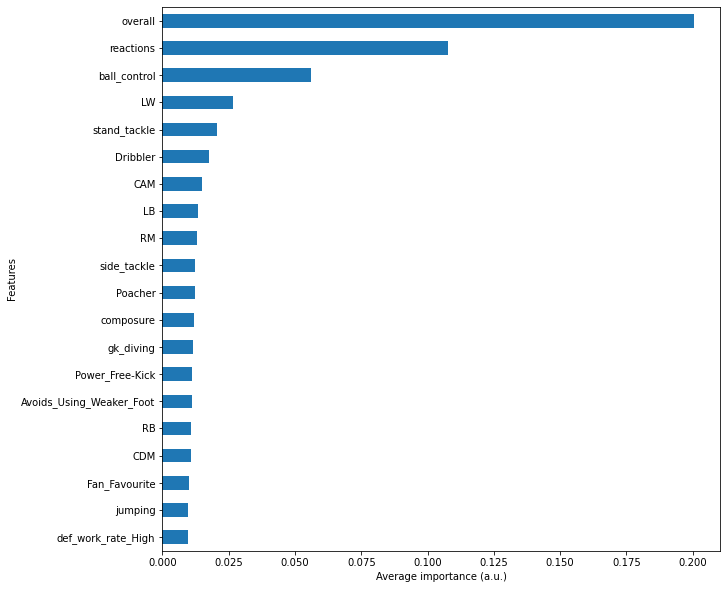

In [18]:
X_train, X_test, y_train, y_test = train_test_split(players_df_wage.drop(columns=['wage']),players_df_wage['wage'],\
                                                    test_size=0.2,random_state=42)

params = {'n_estimators': 1000,
          'min_child_weight': 1,
          'max_depth': 5,
          'learning_rate': 0.05,
          "eval_metric": 'rmse',
          'alpha': 3,
          'lambda': 3,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'scale_pos_weight': 1,
          'seed': 27
         }

n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True)
kf.get_n_splits(X_train, y_train)

scores = []
i = 1
feat_imp = pd.Series(0, index=X_train.columns)
for train_index, valid_index in kf.split(X_train, y_train):
    print('Training the model using fold number {}...'.format(i))
    X_train_train, X_train_valid = X_train.iloc[train_index,:], X_train.iloc[valid_index,:]
    y_train_train, y_train_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_train, y_train_train,eval_set=[(X_train_train, y_train_train), (X_train_valid, y_train_valid)],\
              eval_metric='rmse', early_stopping_rounds=200,verbose=False)
    y_pred_valid = model.predict(X_train_valid)
    score = np.sqrt(mean_squared_error(y_train_valid, y_pred_valid))
    scores.append(score)
    feat_imp += pd.Series(model.feature_importances_, index=X_train.columns)/n_splits
    print('RMSE over the validation set: {:.3f}'.format(score))
    i += 1
    
print('RMSE score average over the validation sets: {:.3f}\n'.format(np.mean(scores)))  

y_pred_xgb = model.predict(X_test)
score_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print('XGBoost RMSE score over the test set: {:.3f}\n'.format(score_xgb))

fig,ax = plt.subplots(figsize=(10,10))
_ = feat_imp.nlargest(20).sort_values().plot(kind='barh',ax=ax)
_ = ax.set_xlabel('Average importance (a.u.)')
_ = ax.set_ylabel('Features')
plt.show()

As expected, "overall" is the most important attribute to predict wage. It is interesting to see that attributes like ["reactions"](https://www.fifplay.com/encyclopedia/player-attribute-reactions/) and ["composure"](https://www.fifplay.com/encyclopedia/player-attribute-composure/), which do not depend on the player's position, are also very important. The [specialities](https://www.fifauteam.com/fifa-20-traits-specialities-guide/) of a player also play an important role on the predictor since they are derived from the attributes and physical details of a player, indicating their specific set of qualities and/or skills. XGBoost made much better predictions than a simple linear regression. Hence, for now on we shall only use this model to predict wage.

Since we are dealing with a wide range of wages (1000 euros to 500000), let's plot the residuals to get a better sense on how our model is performing on unseen data.

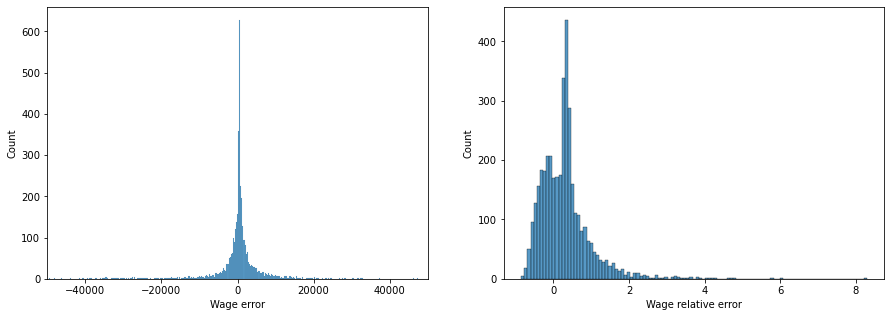

In [19]:
fig,ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
sns.histplot((y_pred_xgb - y_test),ax=ax[0])
sns.histplot((y_pred_xgb - y_test)/y_test,ax=ax[1])
ax[0].set_xlabel('Wage error')
ax[0].set_xlim([-50000,50000])
ax[1].set_xlabel('Wage relative error')
plt.show()

It is nice that the residuals are normally distributed around 0. However, we have many predictions with a very high relative error, which is not desirable (we do not want to predict a wage of 50000 euros when it is possible to sign a contract paying only 10000 euros). Let's see if we can do something about it.

# 2.2 - Dealing with skewness in the target variable

wage skewness: 8.215


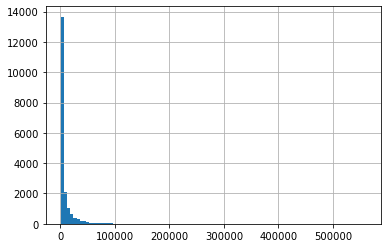

In [20]:
players_df_wage['wage'].hist(bins=100)
print("wage skewness: {:.3f}".format(players_df_wage['wage'].skew()))
plt.show()

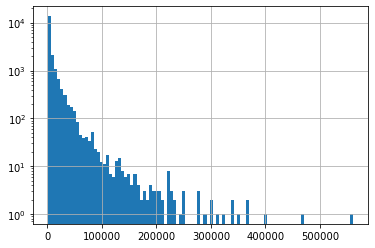

In [21]:
players_df_wage['wage'].hist(bins=100)
plt.yscale('log')
plt.show()

Our data has a huge skewness. Even in log scale we can observe an exponential decay on the number of players as we increase the wage. It may be a good idea to deal with it. There are [some methods for handling skewed data](https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45), which we shall apply here. Let's plot histograms of the player's wages after a log and a boxcox transformation.

wage skewness after a log transformation: 0.990


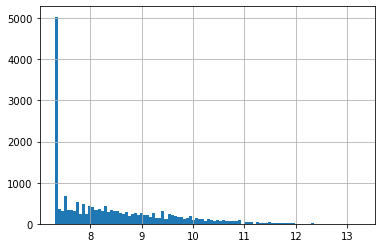

In [22]:
np.log1p(players_df_wage['wage']).hist(bins=100)
print("wage skewness after a log transformation: {:.3f}".format(np.log1p(players_df_wage['wage']).skew()))
plt.show()

wage skewness after a boxcox transformation: 0.250


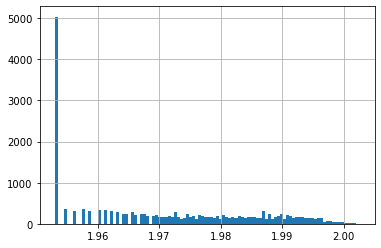

In [23]:
wage_boxcox = stats.boxcox(players_df_wage['wage'])
print("wage skewness after a boxcox transformation: {:.3f}".format(pd.Series(wage_boxcox[0]).skew()))
pd.Series(wage_boxcox[0]).hist(bins=100)
plt.show()

A log transformation reduces skewness by a substantial amount, but the boxcox reduces it much more. However, we still see a high concentration of data in the first bin. For now, let's see if the model performs better after one of these transformations.

In [24]:
# Defining the transformed columns
players_df_wage['wage_boxcox'] = wage_boxcox[0]
players_df_wage['wage_log'] = np.log1p(players_df_wage['wage'])

Training the model using fold number 1...
RMSLE over the validation set: 0.470
Training the model using fold number 2...
RMSLE over the validation set: 0.457
Training the model using fold number 3...
RMSLE over the validation set: 0.468
Training the model using fold number 4...
RMSLE over the validation set: 0.470
Training the model using fold number 5...
RMSLE over the validation set: 0.466
RMSLE score average over the validation sets: 0.466

XGBoost RMSLE score over the test set: 0.467



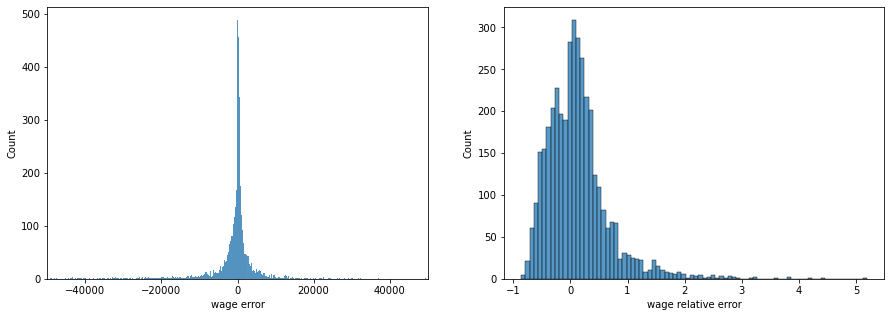

In [25]:
X_train, X_test, y_train, y_test = train_test_split(players_df_wage.drop(columns=['wage','wage_log','wage_boxcox']),players_df_wage['wage_log'],\
                                                    test_size=0.2,random_state=42)
params = {'n_estimators': 1000,
          'min_child_weight': 1,
          'max_depth': 5,
          'learning_rate': 0.05,
          "eval_metric": 'rmse',
          'alpha': 3,
          'lambda': 3,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'scale_pos_weight': 1,
          'seed': 27
         }

n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True)
kf.get_n_splits(X_train, y_train)

scores = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('Training the model using fold number {}...'.format(i))
    X_train_train, X_train_valid = X_train.iloc[train_index,:], X_train.iloc[valid_index,:]
    y_train_train, y_train_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_train, y_train_train,eval_set=[(X_train_train, y_train_train), (X_train_valid, y_train_valid)],\
              eval_metric='rmse', early_stopping_rounds=200,verbose=False)
    y_pred_valid = model.predict(X_train_valid)
    score = np.sqrt(mean_squared_error(y_train_valid, y_pred_valid))
    scores.append(score)
    print('RMSLE over the validation set: {:.3f}'.format(score))
    i += 1
    
print('RMSLE score average over the validation sets: {:.3f}\n'.format(np.mean(scores)))  

y_pred_xgb = model.predict(X_test)
score_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print('XGBoost RMSLE score over the test set: {:.3f}\n'.format(score_xgb))

y_test_inv = np.expm1(y_test)
y_pred_xgb_inv = np.expm1(y_pred_xgb)

fig,ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
sns.histplot((y_pred_xgb_inv - y_test_inv),ax=ax[0])
sns.histplot((y_pred_xgb_inv - y_test_inv)/y_test_inv,ax=ax[1])
ax[0].set_xlabel('wage error')
ax[0].set_xlim([-50000,50000])
ax[1].set_xlabel('wage relative error')
plt.show()

It seems that a log transformation reduced the relative error, but we still have some data that the model miss by more than 100%. Let's see the boxcox transformation.

Training the model using fold number 1...
Boxcox RMSE over the validation set: 0.007
Training the model using fold number 2...
Boxcox RMSE over the validation set: 0.007
Training the model using fold number 3...
Boxcox RMSE over the validation set: 0.007
Training the model using fold number 4...
Boxcox RMSE over the validation set: 0.007
Training the model using fold number 5...
Boxcox RMSE over the validation set: 0.007
Boxcox RMSE score average over the validation sets: 0.007

XGBoost boxcox RMSE score over the test set: 0.007



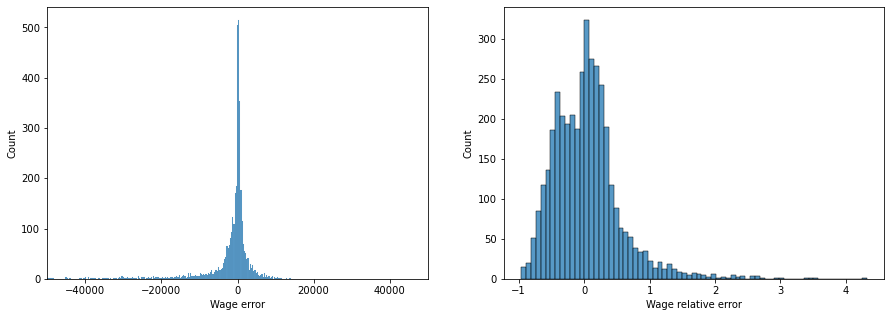

In [26]:
X_train, X_test, y_train, y_test = train_test_split(players_df_wage.drop(columns=['wage','wage_log','wage_boxcox']),players_df_wage['wage_boxcox'],\
                                                    test_size=0.2,random_state=42)
params = {'n_estimators': 1000,
          'min_child_weight': 1,
          'max_depth': 5,
          'learning_rate': 0.05,
          "eval_metric": 'rmse',
          'alpha': 3,
          'lambda': 3,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'scale_pos_weight': 1,
          'seed': 27
         }

n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True)
kf.get_n_splits(X_train, y_train)

scores = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('Training the model using fold number {}...'.format(i))
    X_train_train, X_train_valid = X_train.iloc[train_index,:], X_train.iloc[valid_index,:]
    y_train_train, y_train_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_train, y_train_train,eval_set=[(X_train_train, y_train_train), (X_train_valid, y_train_valid)],\
              eval_metric='rmse', early_stopping_rounds=200,verbose=False)
    y_pred_valid = model.predict(X_train_valid)
    score = np.sqrt(mean_squared_error(y_train_valid, y_pred_valid))
    scores.append(score)
    print('Boxcox RMSE over the validation set: {:.3f}'.format(score))
    i += 1
    
print('Boxcox RMSE score average over the validation sets: {:.3f}\n'.format(np.mean(scores)))  

y_pred_xgb = model.predict(X_test)
score_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print('XGBoost boxcox RMSE score over the test set: {:.3f}\n'.format(score_xgb))

y_test_inv = inv_boxcox(y_test, wage_boxcox[1])
y_pred_xgb_inv = inv_boxcox(y_pred_xgb, wage_boxcox[1])

fig,ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
sns.histplot((y_pred_xgb_inv - y_test_inv),ax=ax[0])
sns.histplot((y_pred_xgb_inv - y_test_inv)/y_test_inv,ax=ax[1])
ax[0].set_xlabel('Wage error')
ax[0].set_xlim([-50000,50000])
ax[1].set_xlabel('Wage relative error')
plt.show()

The result is not very different from what we obtained after the log transformation. Since it is easier to interpret (and invert) a log transformation we will not use the boxcox anymore.

In [27]:
def partial_RMSE(y,y_pred,min_wage):
    partial_SE = 0
    for i in range(len(y)):
        if y.tolist()[i] >= min_wage:
            partial_SE += (y.tolist()[i] - list(y_pred)[i])**2
    return np.sqrt(partial_SE/len(y_test_inv))

print('RMSE of all players wage: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,0)))
print('RMSE of players with wage higher than 10000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,10000)))
print('RMSE of players with wage higher than 20000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,20000)))
print('RMSE of players with wage higher than 50000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,50000)))
print('RMSE of players with wage higher than 100000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,100000)))

RMSE of all players wage: 20599.591104751766
RMSE of players with wage higher than 10000 euros is: 20526.572890368898
RMSE of players with wage higher than 20000 euros is: 20449.895931664825
RMSE of players with wage higher than 50000 euros is: 19839.092214353863
RMSE of players with wage higher than 100000 euros is: 18515.302850497723


In [28]:
wages_vs_predictions = []
for i in range(len(y_test_inv)):
    if y_test_inv.tolist()[i] >= 50000:
        wages_vs_predictions.append([y_test_inv.tolist()[i],list(y_pred_xgb_inv)[i]])
        
wages_vs_predictions[:5]

[[129999.99999999543, 20774.01],
 [69999.99999999846, 20496.031],
 [55000.00000000093, 17073.49],
 [84999.99999999758, 20643.914],
 [84999.99999999758, 18606.248]]

There are some very undesirable predictions for high quality players, as we can see above. Let's investigate further the reason for that.

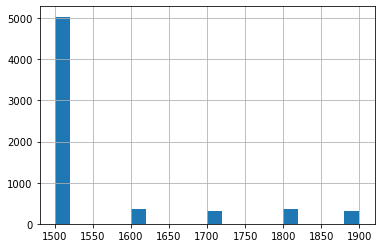

In [29]:
players_df_wage[players_df_wage['wage']<2000]['wage'].hist(bins=20)
plt.show()

There are more than 5000 players with a wage of 1500 euros!

number of players with a wage of less than 10000 euros: 14932


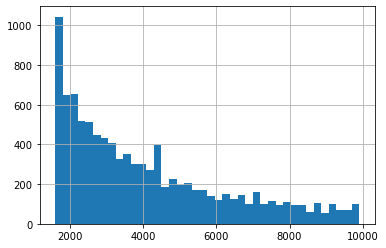

In [30]:
print('number of players with a wage of less than 10000 euros: {}'.format(players_df_wage[players_df_wage['wage']<10000].shape[0]))
players_df_wage[(players_df_wage['wage']<10000)&(players_df_wage['wage']>1500)]['wage'].hist(bins=40)
plt.show()

Almost all of our data is of players that we are actually not very interested for our app. In general, a career mode player is more interested in hiring more valuable professional players. Maybe by randomly deleting a substantial amount of these low quality players (i.e., doing a kind of [undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis)) we can make the model focus more on the other players. We shall also [oversample](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/#:~:text=Random%20undersampling%20involves%20randomly%20selecting,more%20balanced%20distribution%20is%20reached) the high quality players.

In [31]:
players_df_wage['wage_range'] = 0
players_df_wage.loc[(players_df_wage['wage'] > 1500)&(players_df_wage['wage'] <= 3000),'wage_range'] = 1
players_df_wage.loc[(players_df_wage['wage'] > 3000)&(players_df_wage['wage'] <= 6000),'wage_range'] = 2
players_df_wage.loc[(players_df_wage['wage'] > 6000)&(players_df_wage['wage'] <= 10000),'wage_range'] = 3
players_df_wage.loc[(players_df_wage['wage'] > 10000)&(players_df_wage['wage'] <= 20000),'wage_range'] = 4
players_df_wage.loc[(players_df_wage['wage'] > 20000)&(players_df_wage['wage'] <= 30000),'wage_range'] = 5
players_df_wage.loc[(players_df_wage['wage'] > 30000)&(players_df_wage['wage'] <= 50000),'wage_range'] = 6
players_df_wage.loc[(players_df_wage['wage'] > 50000)&(players_df_wage['wage'] <= 100000),'wage_range'] = 7
players_df_wage.loc[players_df_wage['wage'] > 100000,'wage_range'] = 8

In [32]:
# Number of players in each range of sallary
players_df_wage['wage_range'].value_counts()

0    5037
1    4262
2    3734
4    2101
3    1987
5     897
6     727
7     345
8     160
Name: wage_range, dtype: int64

In [33]:
# Undersampling
players_df_wage = players_df_wage.drop(players_df_wage[players_df_wage['wage_range'] == 0].sample(frac=.995,random_state = 42).index)
players_df_wage = players_df_wage.drop(players_df_wage[players_df_wage['wage_range'] == 1].sample(frac=.95,random_state = 42).index)
players_df_wage = players_df_wage.drop(players_df_wage[players_df_wage['wage_range'] == 2].sample(frac=.9,random_state = 42).index)
players_df_wage = players_df_wage.drop(players_df_wage[players_df_wage['wage_range'] == 3].sample(frac=.6,random_state = 42).index)
players_df_wage = players_df_wage.drop(players_df_wage[players_df_wage['wage_range'] == 4].sample(frac=.5,random_state = 42).index)

In [34]:
# Oversampling
sample_wage7 = players_df_wage[players_df_wage['wage_range'] == 7].sample(frac=0.5,random_state = 42,replace=True)
sample_wage8 = players_df_wage[players_df_wage['wage_range'] == 8].sample(frac=0.5,random_state = 42,replace=True)
players_df_wage = pd.concat([players_df_wage,sample_wage7,sample_wage8])

In [35]:
players_df_wage['wage_range'].value_counts()

4    1051
5     897
3     795
6     727
7     517
2     373
8     240
1     213
0      25
Name: wage_range, dtype: int64

wage skewness: 4.122


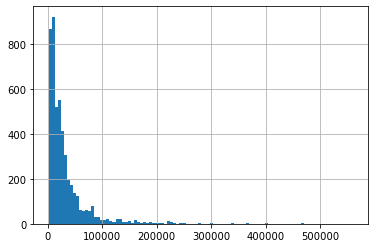

In [36]:
players_df_wage['wage'].hist(bins=100)
print("wage skewness: {:.3f}".format(players_df_wage['wage'].skew()))
plt.show()

wage skewness: -0.015


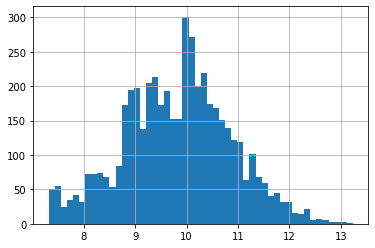

In [37]:
players_df_wage['wage_log'].hist(bins=50)
print("wage skewness: {:.3f}".format(players_df_wage['wage_log'].skew()))
plt.show()

We were able to drastically reduce skewness. Let's hope for the best now.

Training the model using fold number 1...
RMSLE over the validation set: 0.511
Training the model using fold number 2...
RMSLE over the validation set: 0.506
Training the model using fold number 3...
RMSLE over the validation set: 0.482
Training the model using fold number 4...
RMSLE over the validation set: 0.486
Training the model using fold number 5...
RMSLE over the validation set: 0.517
RMSLE score average over the validation sets: 0.500

XGBoost RMSLE score over the test set: 0.475



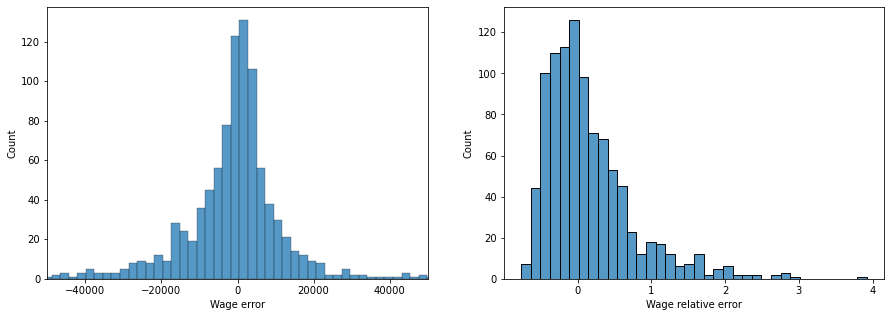

In [38]:
X_train, X_test, y_train, y_test = train_test_split(players_df_wage.drop(columns=['wage','wage_log','wage_boxcox','wage_range']),players_df_wage['wage_log'],\
                                                    test_size=0.2,random_state=42)
params = {'n_estimators': 1000,
          'min_child_weight': 1,
          'max_depth': 5,
          'learning_rate': 0.05,
          "eval_metric": 'rmse',
          'alpha': 3,
          'lambda': 3,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'scale_pos_weight': 1,
          'seed': 27
         }

n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True)
kf.get_n_splits(X_train, y_train)

scores = []
i = 1
for train_index, valid_index in kf.split(X_train, y_train):
    print('Training the model using fold number {}...'.format(i))
    X_train_train, X_train_valid = X_train.iloc[train_index,:], X_train.iloc[valid_index,:]
    y_train_train, y_train_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_train, y_train_train,eval_set=[(X_train_train, y_train_train), (X_train_valid, y_train_valid)],\
              eval_metric='rmse', early_stopping_rounds=200,verbose=False)
    y_pred_valid = model.predict(X_train_valid)
    score = np.sqrt(mean_squared_error(y_train_valid, y_pred_valid))
    scores.append(score)
    print('RMSLE over the validation set: {:.3f}'.format(score))
    i += 1
    
print('RMSLE score average over the validation sets: {:.3f}\n'.format(np.mean(scores)))  

y_pred_xgb = model.predict(X_test)
score_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print('XGBoost RMSLE score over the test set: {:.3f}\n'.format(score_xgb))

y_test_inv = np.expm1(y_test)
y_pred_xgb_inv = np.expm1(y_pred_xgb)

fig,ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
sns.histplot((y_pred_xgb_inv - y_test_inv),ax=ax[0])
sns.histplot((y_pred_xgb_inv - y_test_inv)/y_test_inv,ax=ax[1])
ax[0].set_xlabel('Wage error')
ax[0].set_xlim([-50000,50000])
ax[1].set_xlabel('Wage relative error')
plt.show()

In [39]:
print('RMSE of all players wage: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,0)))
print('RMSE of players with wage higher than 10000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,10000)))
print('RMSE of players with wage higher than 20000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,20000)))
print('RMSE of players with wage higher than 50000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,50000)))
print('RMSE of players with wage higher than 100000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_xgb_inv,100000)))

RMSE of all players wage: 22682.402923346195
RMSE of players with wage higher than 10000 euros is: 22504.295640815264
RMSE of players with wage higher than 20000 euros is: 22116.91582195013
RMSE of players with wage higher than 50000 euros is: 20260.138657037656
RMSE of players with wage higher than 100000 euros is: 18724.570245073


The fact that the RMSLE over the validation sets has increased is not an indicator that our model is performing worse than before. This is because now we have less data about low quality players, hence the errors on the other players have a bigger impact on the final score. Yet, notice (by the partial RMSE scores) how the model performs a little bit better on high quality players now. However, the results aren't good enough yet.

In [40]:
wages_vs_predictions = []
for i in range(len(y_test_inv)):
    if y_test_inv.tolist()[i] >= 50000:
        wages_vs_predictions.append([y_test_inv.tolist()[i],list(y_pred_xgb_inv)[i]])
        
wages_vs_predictions[:5]

[[60000.000000000015, 38791.746],
 [120000.00000000004, 51542.363],
 [75000.00000000004, 43986.63],
 [159999.99999999997, 105020.48],
 [80000.0, 52562.723]]

Well, it seems that undersampling and oversampling the data is not very helpful. The problem is that we have very few data of players with higher wages, so there is not too much that we can do about it. Perhaps by doing some feature engineering we can improve our results a little bit.

# 2.3 - Feature engineering

After thinking for a while, I decided to create some new features, that can be understood from the code below.

In [41]:
# Features given by the mean of each block of attributes
ball_skills = ['ball_control','dribbling']
defence = ['marking','side_tackle','stand_tackle']
mental = ['aggression','reactions','att_position','interceptions','vision','composure']
passing = ['crossing', 'short_pass', 'long_pass']
physical = ['acceleration', 'stamina', 'strength', 'balance', 'sprint_speed', 'agility', 'jumping']
shooting = ['heading', 'shot_power', 'finishing', 'long_shot', 'curve', 'fk_acc', 'penalties', 'volleys']
goalkeeper = ['gk_positioning', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes']

players_df_wage['ball_skills'] = players_df_wage[ball_skills].mean(axis=1)
players_df_wage['defence'] = players_df_wage[defence].mean(axis=1)
players_df_wage['mental'] = players_df_wage[mental].mean(axis=1)
players_df_wage['passing'] = players_df_wage[passing].mean(axis=1)
players_df_wage['physical'] = players_df_wage[physical].mean(axis=1)
players_df_wage['shooting'] = players_df_wage[shooting].mean(axis=1)
players_df_wage['goalkeeper'] = players_df_wage[goalkeeper].mean(axis=1)

# Body mass index of players
players_df_wage['bmi'] = players_df['weight']/(players_df['height']/100)**2

# Number of specialities and traits
specialities = ['Dribbler','Distance_Shooter','Crosser','FK_Specialist','Acrobat','Clinical_Finisher','Speedster','Playmaker','Strength',\
               'Complete_Midfielder','Complete_Forward','Complete_Defender','Tackling','Tactician','Poacher','Aerial_Threat','Engine']

players_df_wage['number_specialities_traits'] = players_df_wage[specialities_traits_categories].sum(axis=1) -1
players_df_wage['number_specialities'] = players_df_wage[specialities].sum(axis=1)
players_df_wage['number_traits'] = players_df_wage['number_specialities_traits'] - players_df_wage['number_specialities']

# Number of positions that the player can play
players_df_wage['number_preferred_positions'] = players_df_wage[preferred_positions_categories].sum(axis=1)

# Number of attributes above a certain threshold
attributes = ball_skills + defence + mental + passing + physical + shooting + goalkeeper
players_df_wage['number_attributes_greater_95'] = (players_df_wage[attributes]>=95).sum(axis=1)
players_df_wage['number_attributes_greater_90'] = (players_df_wage[attributes]>=90).sum(axis=1)
players_df_wage['number_attributes_greater_85'] = (players_df_wage[attributes]>=85).sum(axis=1)
players_df_wage['number_attributes_greater_80'] = (players_df_wage[attributes]>=80).sum(axis=1)
players_df_wage['number_attributes_greater_75'] = (players_df_wage[attributes]>=75).sum(axis=1)
players_df_wage['number_attributes_greater_70'] = (players_df_wage[attributes]>=70).sum(axis=1)

# Number of attributes within a certain range
players_df_wage['number_attributes_greater_90_less_95'] = players_df_wage['number_attributes_greater_90'] - players_df_wage['number_attributes_greater_95']
players_df_wage['number_attributes_greater_85_less_90'] = players_df_wage['number_attributes_greater_85'] - players_df_wage['number_attributes_greater_90']
players_df_wage['number_attributes_greater_80_less_85'] = players_df_wage['number_attributes_greater_80'] - players_df_wage['number_attributes_greater_85']
players_df_wage['number_attributes_greater_75_less_80'] = players_df_wage['number_attributes_greater_75'] - players_df_wage['number_attributes_greater_80']
players_df_wage['number_attributes_greater_70_less_75'] = players_df_wage['number_attributes_greater_70'] - players_df_wage['number_attributes_greater_75']

Edit: For our application, it is not convenient to ask the user to fill so many information that turns out being not very useful to the model (See section 4). Thus, we drop all traits features (the specialities will not be dropped since they are important to the predictions and [can be obtained from the player's attributes](https://www.fifauteam.com/fifa-20-traits-specialities-guide/)).

In [43]:
traits = list(set(specialities_traits_categories) - set(specialities))
players_df_wage = players_df_wage.drop(columns=traits+['number_specialities_traits','number_traits'])

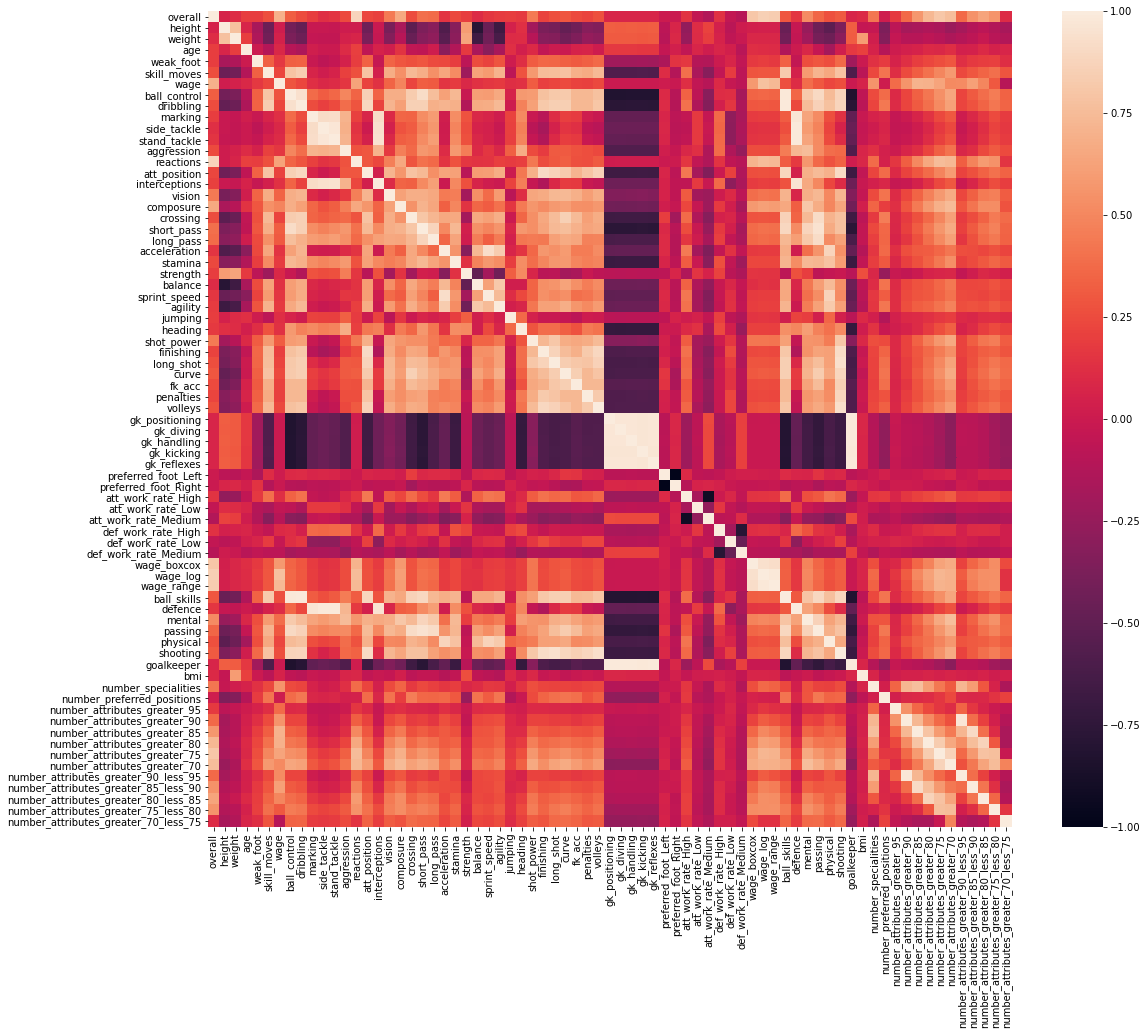

In [47]:
fig,ax = plt.subplots(1,1,figsize=(18,15))
sns.heatmap(players_df_wage.drop(columns=specialities+preferred_positions_categories).corr(),ax=ax)
plt.show()

Some of the new features we just defined are highly correlated with wage. However, they are also highly correlated with overall, so that maybe we do not achieve a big improvement with those features.

Training the model using fold number 1...
RMSLE: 0.496
Training the model using fold number 2...
RMSLE: 0.502
Training the model using fold number 3...
RMSLE: 0.505
Training the model using fold number 4...
RMSLE: 0.496
Training the model using fold number 5...
RMSLE: 0.510
RMSLE score over the validation sets: 0.502



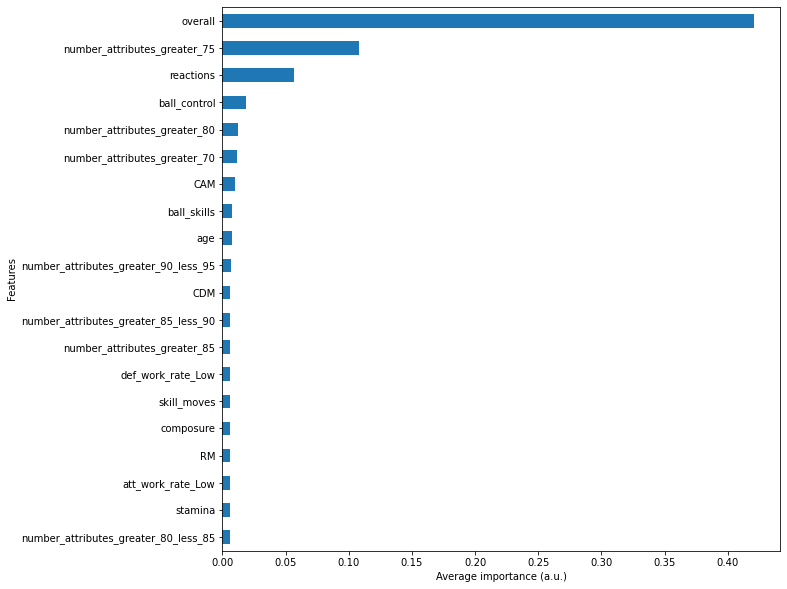

In [48]:
X_train, X_test, y_train, y_test = train_test_split(players_df_wage.drop(columns=['wage','wage_boxcox','wage_log','wage_range']),\
                                                    players_df_wage['wage_log'], test_size=0.2,random_state=42,\
                                                    stratify=players_df_wage['wage_range'])

params = {'n_estimators': 1000,
          'min_child_weight': 1,
          'max_depth': 5,
          'learning_rate': 0.05,
          "eval_metric": 'rmse',
          'alpha': 3,
          'lambda': 3,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'scale_pos_weight': 1,
          'seed': 27
         }

n_splits = 5
kf = KFold(n_splits=n_splits,shuffle=True)
splits = kf.split(X_train, y_train)
scores = []
i = 1
feat_imp = pd.Series(0, index=X_train.columns)
for train_index, valid_index in splits:
    print('Training the model using fold number {}...'.format(i))
    X_train_train, X_train_valid = X_train.iloc[train_index,:], X_train.iloc[valid_index,:]
    y_train_train, y_train_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

    model = xgb.XGBRegressor(**params)
    model.fit(X_train_train, y_train_train,eval_set=[(X_train_valid, y_train_valid)],\
              eval_metric='rmse', early_stopping_rounds=100,verbose=False)
    y_pred_valid = model.predict(X_train_valid)
    feat_imp += pd.Series(model.feature_importances_, index=X_train.columns)/n_splits
    score = np.sqrt(mean_squared_error(y_train_valid, y_pred_valid))
    scores.append(score)
    print('RMSLE: {:.3f}'.format(score))
    i += 1
    
print('RMSLE score over the validation sets: {:.3f}\n'.format(np.mean(scores)))

fig,ax = plt.subplots(figsize=(10,10))
_ = feat_imp.nlargest(20).sort_values().plot(kind='barh',ax=ax)
_ = ax.set_xlabel('Average importance (a.u.)')
_ = ax.set_ylabel('Features')
plt.show()

There was a very small improvement, which may not be significantly. Still, let's see if we can achieve better results by doing some hyperparameter tuning.

# 2.4 - Model tuning

Tuning a gradient boost regressor is not an easy task due to the [large amount of hyperparameters](https://xgboost.readthedocs.io/en/latest/parameter.html). Here we follow [this guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/), which establishes an order based on the relevance / priority of each parameter.

In [37]:
def get_xgb_score(params,X_train,y_train):
    
    n_splits = 5
    kf = KFold(n_splits=n_splits,shuffle=True)
    splits = kf.split(X_train, y_train)

    scores = []
    i = 1
    for train_index, valid_index in splits:
        print('Training the model using fold number {}...'.format(i))
        X_train_train, X_train_valid = X_train.iloc[train_index,:], X_train.iloc[valid_index,:]
        y_train_train, y_train_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

        model = xgb.XGBRegressor(**params)
        model.fit(X_train_train, y_train_train,eval_set=[(X_train_valid, y_train_valid)],\
                  eval_metric='rmse', early_stopping_rounds=100,verbose=False)
        y_pred_valid = model.predict(X_train_valid)
        score = np.sqrt(mean_squared_error(y_train_valid, y_pred_valid))
        scores.append(score)
        print('RMSLE: {:.3f}'.format(score))
        i += 1
        
    rmsle = np.mean(scores)
    return rmsle
    
rmsle = 100
best_params = {'min_child_weight': 1, 'max_depth': 5, 'score': rmsle}

for max_depth in range(4,7):
    for min_child_weight in range(1,10,2):
        print('max_depth: {}; min_child_weight: {}'.format(max_depth,min_child_weight))
        
        params = {'n_estimators': 1000,
          'min_child_weight': min_child_weight,
          'max_depth': max_depth,
          'learning_rate': 0.1,
          "eval_metric": 'rmse',
          'gamma': 0,
          'alpha': 0,
          'lambda': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'scale_pos_weight': 1,
          'seed': 27
         } 
        
        current_rmsle = get_xgb_score(params,X_train,y_train)
        if current_rmsle < rmsle:
            rmsle = current_rmsle
            best_params = {'min_child_weight': min_child_weight, 'max_depth': max_depth, 'score': rmsle}
        clear_output(wait=True)
        
print(best_params)

{'min_child_weight': 3, 'max_depth': 6, 'score': 0.4944217776400229}


In [39]:
best_params = {'gamma': 0, 'score': rmsle}
for gamma in [0.1,0.3,0.7,1,3,10,30,100]:
    print('gamma: {}'.format(gamma))
        
    params = {'n_estimators': 1000,
        'min_child_weight': 3,
        'max_depth': 6,
        'learning_rate': 0.1,
        "eval_metric": 'rmse',
        'gamma': gamma,
        'alpha': 0,
        'lambda': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': 1,
        'seed': 27
        } 
        
    current_rmsle = get_xgb_score(params,X_train,y_train)
    if current_rmsle < rmsle:
        rmsle = current_rmsle
        best_params = {'gamma': gamma, 'score': rmsle}
    clear_output(wait=True)
        
print(best_params)

{'gamma': 0, 'score': 0.4944217776400229}


In [41]:
best_params = {'subsample': 0.8, 'colsample_bytree': 0.8, 'score': rmsle}

for subsample in [i/10.0 for i in range(6,11)]:
    for colsample_bytree in [i/10.0 for i in range(6,11)]:
        print('subsample: {}; colsample_bytree : {}'.format(subsample,colsample_bytree ))
        
        params = {'n_estimators': 1000,
          'min_child_weight': 5,
          'max_depth': 6,
          'learning_rate': 0.1,
          "eval_metric": 'rmse',
          'gamma': 0,
          'alpha': 0,
          'lambda': 1,
          'subsample': subsample,
          'colsample_bytree': colsample_bytree,
          'scale_pos_weight': 1,
          'seed': 27
         } 
        
        current_rmsle = get_xgb_score(params,X_train,y_train)
        if current_rmsle < rmsle:
            rmsle = current_rmsle
            best_params = {'subsample': subsample, 'colsample_bytree': colsample_bytree, 'score': rmsle}
        clear_output(wait=True)
        
print(best_params)

{'subsample': 0.8, 'colsample_bytree': 0.8, 'score': 0.4930341361496092}


In [42]:
best_params = {'alpha': 0, 'lambda': 1, 'score': rmsle}

for alpha in [0,0.1,0.3,1,3,10]:
    for Lambda in [0.3,1,3]:
        print('alpha: {}; lambda: {}'.format(alpha,Lambda))
        
        params = {'n_estimators': 1000,
          'min_child_weight': 5,
          'max_depth': 6,
          'learning_rate': 0.1,
          "eval_metric": 'rmse',
          'gamma': 0,
          'alpha': alpha,
          'lambda': Lambda,
          'subsample': 0.9,
          'colsample_bytree': 0.8,
          'scale_pos_weight': 1,
          'seed': 27
         } 
        
        current_rmsle = get_xgb_score(params,X_train,y_train)
        if current_rmsle < rmsle:
            rmsle = current_rmsle
            best_params = {'alpha': alpha, 'Lambda': Lambda, 'score': rmsle}
        clear_output(wait=True)
        
print(best_params)

{'alpha': 0, 'lambda': 1, 'score': 0.4930341361496092}


In [43]:
params = {'n_estimators': 5000,
          'min_child_weight': 5,
          'max_depth': 6,
          'learning_rate': 0.01,
          "eval_metric": 'rmse',
          'gamma': 0,
          'alpha': 0,
          'lambda': 1,
          'subsample': 0.9,
          'colsample_bytree': 0.8,
          'scale_pos_weight': 1,
          'seed': 27
         } 

print('RMSLE with more estimators: {}'.format(get_xgb_score(params,X_train,y_train)))

Training the model using fold number 1...
RMSLE: 0.474
Training the model using fold number 2...
RMSLE: 0.482
Training the model using fold number 3...
RMSLE: 0.490
Training the model using fold number 4...
RMSLE: 0.502
Training the model using fold number 5...
RMSLE: 0.493
RMSLE with more estimators: 0.4882261046520998


XGBoost RMSLE score over the training set: 0.042

XGBoost RMSLE score over the test set: 0.480



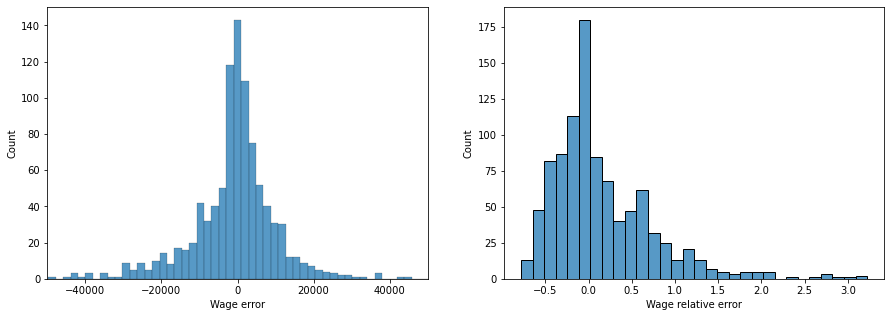

In [45]:
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train, eval_set=[(X_train,y_train)], eval_metric='rmse', early_stopping_rounds=100,verbose=False)
 

    
y_pred_train = model.predict(X_train)
train_rmsle = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('XGBoost RMSLE score over the training set: {:.3f}\n'.format(train_rmsle))    
    
y_pred_test = model.predict(X_test)
test_rmsle = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('XGBoost RMSLE score over the test set: {:.3f}\n'.format(test_rmsle))

y_test_inv = np.expm1(y_test)
y_pred_test_inv = np.expm1(y_pred_test)

fig,ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
sns.histplot((y_pred_test_inv - y_test_inv),ax=ax[0])
sns.histplot((y_pred_test_inv - y_test_inv)/y_test_inv,ax=ax[1])
ax[0].set_xlabel('Wage error')
ax[0].set_xlim([-50000,50000])
ax[1].set_xlabel('Wage relative error')
plt.show()

The model overfits the training set, however, that should not be a problem, as discussed in [this topic](https://stats.stackexchange.com/questions/204489/discussion-about-overfit-in-xgboost)

In [46]:
print('RMSE of all players wage: {}'.format(partial_RMSE(y_test_inv,y_pred_test_inv,0)))
print('RMSE of players with wage higher than 10000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_test_inv,10000)))
print('RMSE of players with wage higher than 20000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_test_inv,20000)))
print('RMSE of players with wage higher than 50000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_test_inv,50000)))
print('RMSE of players with wage higher than 100000 euros is: {}'.format(partial_RMSE(y_test_inv,y_pred_test_inv,100000)))

RMSE of all players wage: 17730.144466813264
RMSE of players with wage higher than 10000 euros is: 17526.77716891368
RMSE of players with wage higher than 20000 euros is: 17027.650813783173
RMSE of players with wage higher than 50000 euros is: 15199.958671531474
RMSE of players with wage higher than 100000 euros is: 13946.759514480169


In [47]:
wages_vs_predictions = []
for i in range(len(y_test_inv)):
    if y_test_inv.tolist()[i] >= 50000:
        wages_vs_predictions.append([y_test_inv.tolist()[i],list(y_pred_test_inv)[i]])
        
wages_vs_predictions[:5]

[[75000.00000000004, 71343.73],
 [50000.000000000015, 45260.11],
 [134999.99999999997, 77896.36],
 [60000.000000000015, 59492.188],
 [189999.9999999999, 160677.48]]

We were able to achieve a significantly improvement with feature engineering and hyperparameter tuning. The predictions are not perfect due to the lack of relevant data, and could be improved by getting more data from wages in career mode, instead of only using the initial wages of contracts already given initially by the game.

# 2.5 - Final model

For our app, it is important to train the [final machine learning model](https://machinelearningmastery.com/train-final-machine-learning-model/) in the whole dataset since we have very few data. As discussed [in this topic](https://datascience.stackexchange.com/questions/33008/is-it-always-better-to-use-the-whole-dataset-to-train-the-final-model), this may pose some problems that we would only know by empirical evidence (monitoring the model in production).

After retraining the model, we save it in a pickle format for later use, as described in [this video made by Ken Jee](https://www.youtube.com/watch?v=nUOh_lDMHOU&list=PL2zq7klxX5ASFejJj80ob9ZAnBHdz5O1t&index=6&t=0s&ab_channel=KenJee) and [this post on medium](https://towardsdatascience.com/productionize-a-machine-learning-model-with-flask-and-heroku-8201260503d2).

In [50]:
params = {'n_estimators': 5000,
          'min_child_weight': 5,
          'max_depth': 6,
          'learning_rate': 0.01,
          "eval_metric": 'rmse',
          'gamma': 0,
          'alpha': 0,
          'lambda': 1,
          'subsample': 0.9,
          'colsample_bytree': 0.8,
          'scale_pos_weight': 1,
          'seed': 27
         } 
X = players_df_wage.drop(columns=['wage','wage_boxcox','wage_log','wage_range'])
y = players_df_wage['wage_log']
model = xgb.XGBRegressor(**params)
model.fit(X, y, eval_set=[(X,y)], eval_metric='rmse', early_stopping_rounds=100,verbose=False)

pickl = {'model': model}
pickle.dump(pickl, open( 'model_logwage' + ".p", "wb" ))

# 3 - Preferred positions predictions

# 3.1 - First model

In [146]:
# number_preferred_positions should be dropped to avoid data leakage
players_df_positions = players_df_wage.copy().drop(columns = ['age','wage','wage_boxcox','wage_log','wage_range','number_preferred_positions'])

# We are not interesting in goalkeepers since they do not play in other positions
players_df_positions = players_df_positions[players_df_positions['GK'] == 0].drop(columns=['GK','gk_positioning', 'gk_diving',\
                                                                                          'gk_handling', 'gk_kicking', 'gk_reflexes', 'goalkeeper'])
players_df_positions.head()

,overall,height,weight,weak_foot,skill_moves,ball_control,dribbling,marking,side_tackle,stand_tackle,...,number_attributes_greater_90,number_attributes_greater_85,number_attributes_greater_80,number_attributes_greater_75,number_attributes_greater_70,number_attributes_greater_90_less_95,number_attributes_greater_85_less_90,number_attributes_greater_80_less_85,number_attributes_greater_75_less_80,number_attributes_greater_70_less_75
0,94,170,72,4,4,96,97,33,26,37,...,15,18,19,21,22,9,3,1,2,1
1,93,187,83,4,5,92,89,28,24,32,...,9,16,20,23,24,4,7,4,3,1
2,92,175,68,5,5,95,96,35,29,30,...,8,17,21,21,21,5,9,4,0,0
3,91,193,92,3,2,77,70,93,86,93,...,6,9,12,16,19,6,3,3,4,3
5,91,181,70,5,4,91,87,68,53,62,...,9,13,17,22,23,9,4,4,5,1


The problem of predicting the preferred positions of a player is a [multi-label classification task](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff). We must predict different classes that are not mutually exclusive, in contrast to a multi-class classification problem. Our approach to the problem is by using a random forest model and the (averaged) AUC score. For multi-label classification, there are [many different metrics that can be used](https://medium.com/towards-artificial-intelligence/understanding-multi-label-classification-model-and-accuracy-metrics-1b2a8e2648ca). However, **we do not want to predict the exact labels given by  FIFA 20**. Instead, we want to use these labels to recommend other possible positions for a given player, while also getting the FIFA 20 labels right. For this reason, a metric that is based on the probability such as the AUC score is better for our purpose.

We can also do some simple hyperparameter tuning right on the beginning since it not take too long in a random forest model. A good guide on the meaning of each hyperparameter and how to correctly tune them can be find [here](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/). We use GridSearchCV to accomplish that.

In [148]:
positions = ['RW', 'ST', 'CF', 'LW', 'CAM', 'CB', 'CM', 'CDM', 'LM', 'RB', 'RM', 'LB', 'LWB', 'RWB']

X_train, X_test, y_train, y_test = train_test_split(players_df_positions.drop(columns=positions),players_df_positions[positions],\
                                                    test_size=0.2,random_state=42)

rf = RandomForestClassifier(random_state=42,n_estimators = 50)
param_grid = {'max_depth':[4,5,6,None],"min_samples_leaf": [1, 5, 10], "min_samples_split": [2, 5, 10, 20]}
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5,scoring='roc_auc')

grid_rf_result = grid_rf.fit(X_train,y_train)
best_score_rf, best_params_rf = grid_rf_result.best_score_,grid_rf_result.best_params_
print("Random Forest - AUC: %f using %s" % (best_score_rf, best_params_rf))

Random Forest - AUC: 0.930831 using {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [149]:
y_pred = grid_rf.predict(X_train)
print('Accuracy over the training set: {}'.format(accuracy_score(y_train, y_pred)))
y_pred = grid_rf.predict(X_test)
print('Accuracy over the test set: {}'.format(accuracy_score(y_test, y_pred)))

Accuracy over the training set: 0.5496076233183856
Accuracy over the test set: 0.38565022421524664


N.B.: the accuracy score is obtained using a threshold of 0.5 for the predicted probabilities.

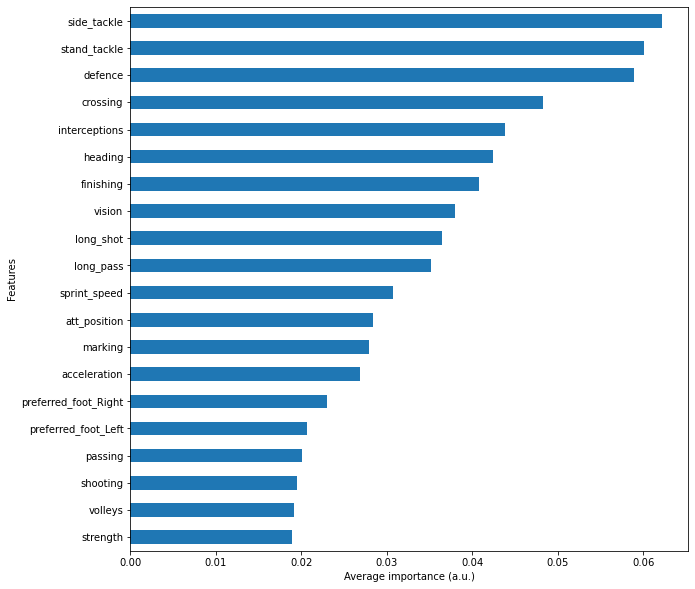

In [150]:
feat_imp = pd.Series(grid_rf_result.best_estimator_.feature_importances_, index=X_train.columns)

fig,ax = plt.subplots(figsize=(10,10))
_ = feat_imp.nlargest(20).sort_values().plot(kind='barh',ax=ax)
_ = ax.set_xlabel('Average importance (a.u.)')
_ = ax.set_ylabel('Features')
plt.show()

# 3.2 - Feature engineering

My idea for new features is very simple: instead of trying to predict the position based on the values of each attribute, we create features that indicate the importance of each feature to the overall ability of the player. The preferred positions of a player should depend on what features are more or less important to his overall. Thus, after testing how some different normalizations impact the model AUC score, we see that a simple subtraction is the best way to do it here.

In [151]:
attributes = ball_skills + defence + mental + passing + physical + shooting

for attribute in attributes:
    players_df_positions[attribute+'_minus_ovr'] = players_df_positions[attribute] - players_df_positions['overall']
    
players_df_positions['ball_skills_minus_ovr'] = players_df_positions['ball_skills'] - players_df_positions['overall']
players_df_positions['defence_minus_ovr'] = players_df_positions['defence'] - players_df_positions['overall']
players_df_positions['mental_minus_ovr'] = players_df_positions['mental'] - players_df_positions['overall']
players_df_positions['passing_minus_ovr'] = players_df_positions['passing'] - players_df_positions['overall']
players_df_positions['physical_minus_ovr'] = players_df_positions['physical'] - players_df_positions['overall']
players_df_positions['shooting_minus_ovr'] = players_df_positions['shooting'] - players_df_positions['overall']

# 3.3 - Model tuning and predictions

In [152]:
X_train, X_test, y_train, y_test = train_test_split(players_df_positions.drop(columns=positions),players_df_positions[positions],\
                                                    test_size=0.2,random_state=42)

rf = RandomForestClassifier(random_state=42,n_estimators = 50)
param_grid = {'max_depth':[4,5,6,None],"min_samples_leaf": [1, 5, 10], "min_samples_split": [2, 5, 10, 20]}
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5,scoring='roc_auc')

grid_rf_result = grid_rf.fit(X_train,y_train)
best_score_rf, best_params_rf = grid_rf_result.best_score_,grid_rf_result.best_params_
print("Random Forest - AUC: %f using %s" % (best_score_rf, best_params_rf))

Random Forest - AUC: 0.934155 using {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [153]:
y_pred = grid_rf.predict(X_train)
print('Accuracy over the training set: {}'.format(accuracy_score(y_train, y_pred)))
y_pred = grid_rf.predict(X_test)
print('Accuracy over the test set: {}'.format(accuracy_score(y_test, y_pred)))

Accuracy over the training set: 0.5770739910313901
Accuracy over the test set: 0.4069506726457399


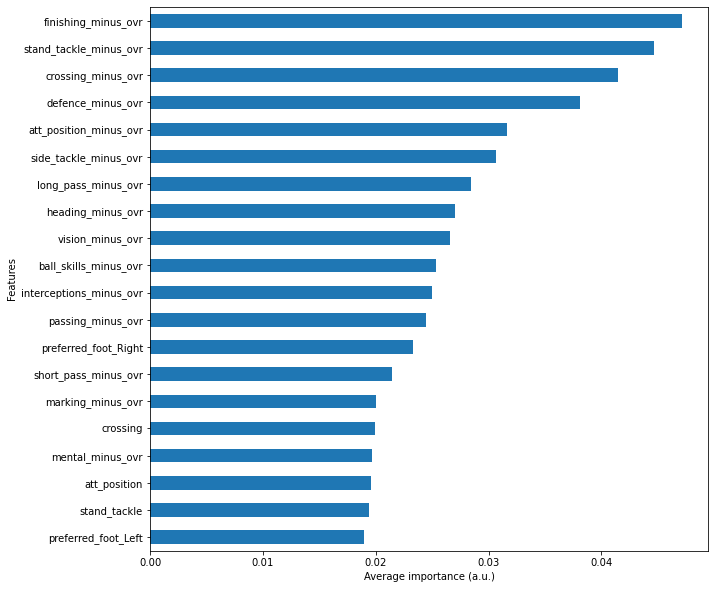

In [154]:
feat_imp = pd.Series(grid_rf_result.best_estimator_.feature_importances_, index=X_train.columns)

fig,ax = plt.subplots(figsize=(10,10))
_ = feat_imp.nlargest(20).sort_values().plot(kind='barh',ax=ax)
_ = ax.set_xlabel('Average importance (a.u.)')
_ = ax.set_ylabel('Features')
plt.show()

It is clear from the above plot that the features we created are really good for predicting positions. The scores also improved by a good amount after the feature engineering. So, let's pickle our model after training on the whole dataset.

In [155]:
X = players_df_positions.drop(columns=positions)
y = players_df_positions[positions]
model = RandomForestClassifier(random_state=42,n_estimators = 50,min_samples_leaf=5)
model.fit(X, y)

pickl = {'model': model}
pickle.dump(pickl, open( 'model_positions' + ".p", "wb" ))

In [156]:
y_pred = model.predict(X)
print('Accuracy over the training set: {}'.format(accuracy_score(y, y_pred)))

Accuracy over the training set: 0.5733183856502242


In our app, we are not interested in predicting exactly the same positions labeled by FIFA 20. Instead, we would like to be able of predicting a high probability for these labeled positions, but also find other possible positions. For this reason, we use the method predict_proba() and order the positions in a descending order based on its probability of being true.

Let's do that now and compare with the labels given by FIFA 20.

In [176]:
#probas = model.predict_proba(X.iloc[:1])
probas = model.predict_proba(X)

In [185]:
predicted_probas = []
for i in range(14):
    predicted_probas = predicted_probas + [int(round(probas[i][0,1],2)*100)]

positions_df = y.iloc[0].to_frame(name='values')
positions_df['probabilities (%)'] = predicted_probas
positions_df.sort_values('probabilities (%)',ascending=False)

,values,probabilities (%)
ST,1,49
CF,1,43
CAM,0,41
RW,1,37
LW,0,31
LM,0,15
RM,0,12
CM,0,8
CB,0,0
CDM,0,0


The model ordered the positions almost in a way that the first three positions match the FIFA 20 labels.

In [179]:
predicted_probas = []
for i in range(14):
    predicted_probas = predicted_probas + [int(round(probas[i][10,1],3)*100)]

positions_df = y.iloc[10].to_frame(name='values')
positions_df['probabilities (%)'] = predicted_probas
positions_df.sort_values('probabilities (%)',ascending=False)

,values,probabilities (%)
ST,1,81
LW,1,68
RW,1,50
LM,0,8
CF,0,7
RM,0,4
CAM,0,3
CB,0,0
CM,0,0
CDM,0,0


Here our model classified 100% of the labels correctly.

In [180]:
predicted_probas = []
for i in range(14):
    predicted_probas = predicted_probas + [int(round(probas[i][3,1],3)*100)]

positions_df = y.iloc[3].to_frame(name='values')
positions_df['probabilities (%)'] = predicted_probas
positions_df.sort_values('probabilities (%)',ascending=False)

,values,probabilities (%)
CB,1,98
RB,0,4
CDM,0,3
LB,0,2
RWB,0,1
RW,0,0
ST,0,0
CF,0,0
LW,0,0
CAM,0,0


We can see that the model has a higher ability of classifying centre-backs.

In [182]:
predicted_probas = []
for i in range(14):
    predicted_probas = predicted_probas + [int(round(probas[i][2000,1],3)*100)]

positions_df = y.iloc[2000].to_frame(name='values')
positions_df['probabilities (%)'] = predicted_probas
positions_df.sort_values('probabilities (%)',ascending=False)

,values,probabilities (%)
LB,1,82
LM,0,15
LWB,0,15
RB,0,14
CM,0,7
RM,0,7
CB,0,6
CDM,0,4
RWB,0,2
LW,0,1


Same here. Four our app, we should recommend the top positions for the user. However, we should take care to not recommend positions that are very unlikely that the player will perform well. Hence, we must define a threshold for recommending positions based on the probability predicted by the model.

# 4 - About the application

In our app, we want to ease the life of the user by reducing the amount of information he must pass to the API. For this reason, all the feature engineering will be made under the hood, so that the user will only fill the basic information of the player. Also, since the specialities can be obtaine from the attributes, we will not require that as an input.

Below, we sketch the strucutre of our Flask API using a test set of player, justifying the reasoning behind every code that can be find in its corresponding folder.

In [79]:
# Information that should be provided by the user
input_columns = ['overall', 'height', 'weight', 'age', 'weak_foot', 'skill_moves',\
                  'preferred_foot_Left', 'preferred_foot_Right', 'att_work_rate_High', 'att_work_rate_Low',\
                  'att_work_rate_Medium', 'def_work_rate_High', 'def_work_rate_Low', 'def_work_rate_Medium',\
                 'RW', 'ST', 'CF', 'LW', 'CAM', 'CB', 'GK', 'CM', 'CDM', 'LM', 'RB', 'RM', 'LB', 'LWB', 'RWB'] + attributes
# Data for testing our ideas for the API
data_test = players_df_wage[input_columns].copy()

Below we define the functions for getting the values of the specialities columns and apply it to the data_test. The requirements for each speciality can be found at https://fifa.fandom.com/wiki/Speciality

In [107]:
def is_Poacher(row):
    if row['att_work_rate_High'] == 0:
        if (row['heading']>=75)&(row['finishing']>=85):
            return 1
        else:
            return 0
    else:
        return 0
    
def is_Speedster(row):
    if (row['sprint_speed'] + row['acceleration']) >= 180:
        return 1
    else:
        return 0
    
def is_Aerial_Threat(row):
    if row['height'] < 188:
        return 0
    elif (row['height'] >=188)&(row['height'] <= 194):
        if (row['heading'] >=90)&((row['strength'] >= 85)|(row['jumping'] >= 85)):
            return 1
        else:
            return 0
    elif row['height'] > 194:
        if row['heading'] >= 75:
            return 1
        else:
            return 0
    else:
        return 0

def is_Dribbler(row):
    if (row['dribbling'] >= 86)&(row['skill_moves'] == 5):
        return 1
    elif (row['dribbling']>=86)&(row['balance']>=75):
        return 1
    else:
        return 0
    
def is_Playmaker(row):
    if row[['CM','CDM','CAM']].sum() >= 1:
        if (row['vision'] >= 86)&(row['short_pass'] >= 86)&(row['long_pass'] >= 73):
            return 1
        else:
            return 0
    else:
        return 0
    
def is_Engine(row):
    if (row['att_work_rate_High'] == 1)&(row['def_work_rate_High'] == 1)&(row['stamina'] >= 86):
        return 1
    else:
        return 0
    
def is_Distance_Shooter(row):
    if (row['long_shot'] + row['shot_power']) >= 174:
        return 1
    else:
        return 0
    
def is_Crosser(row):
    if (row['crossing'] >= 86)&(row['curve'] >= 80):
        return 1
    else:
        return 0
    
def is_FK_Specialist(row):
    if (row['fk_acc'] >=86)&((row['curve'] >= 85)|(row['shot_power'] >= 85)):
        return 1
    else:
        return 0
    
def is_Tackling(row):
    if (row['stand_tackle'] >= 86)&(row['side_tackle'] >= 85):
        return 1
    else:
        return 0
    
def is_Tactician(row):
    if (row['interceptions'] >= 86)&(row['reactions'] >= 80):
        return 1
    else:
        return 0
    
def is_Acrobat(row):
    if (row['agility'] >= 90):
        return 1
    elif (row['agility'] >= 86)&(row['reactions'] >= 80):
        return 1
    else:
        return 0
    
def is_Strength(row):
    if (row['weight'] <= 82)&(row['strength'] >= 90):
        return 1
    elif (row['weight'] > 82)&(row['strength'] >= 86):
        return 1
    else:
        return 0
    
def is_Clinical_Finisher(row):
    if (row['finishing'] >= 86)&(row['long_shot'] >= 80):
        return 1
    else:
        return 0
    
def is_Complete_Defender(row):
    if (row['Tactician'] == 1)&(row['Tackling'] == 1):
        if row[['Strength','Acrobat','Aerial_Threat']].sum() >= 1:
            return 1
        else:
            return 0
    else:
        return 0
    
def is_Complete_Midfielder(row):
    if (row['Playmaker'] == 1):
        if row[['Distance_Shooter', 'Engine', 'Dribbler', 'FK_Specialist', 'Tackling', 'Crosser', 'Clinical_Finisher']].sum() >= 2:
            return 1
        else:
            return 0
    else:
        return 0

def is_Complete_Forward(row):
    important = ['Clinical_Finisher','Poacher']
    standard = ['Aerial_Threat', 'Speedster', 'Dribbler', 'Strength']
    if row[important].sum() >= 1:
        if row[standard].sum() >= 2:
            return 1
    elif row[important].sum() >= 2:
        if row[standard].sum() >= 1:
            return 1
        
    return 0

In [108]:
data_test['Dribbler'] = data_test.apply(is_Dribbler,axis=1)
data_test['Distance_Shooter'] = data_test.apply(is_Distance_Shooter,axis=1)
data_test['Crosser'] = data_test.apply(is_Crosser,axis=1)
data_test['FK_Specialist'] = data_test.apply(is_FK_Specialist,axis=1)
data_test['Acrobat'] = data_test.apply(is_Acrobat,axis=1)
data_test['Clinical_Finisher'] = data_test.apply(is_Clinical_Finisher,axis=1)
data_test['Speedster'] = data_test.apply(is_Speedster,axis=1)
data_test['Playmaker'] = data_test.apply(is_Playmaker,axis=1)
data_test['Strength'] = data_test.apply(is_Strength,axis=1)
data_test['Tackling'] = data_test.apply(is_Tackling,axis=1)
data_test['Tactician'] = data_test.apply(is_Tactician,axis=1)
data_test['Poacher'] = data_test.apply(is_Poacher,axis=1)
data_test['Aerial_Threat'] = data_test.apply(is_Aerial_Threat,axis=1)
data_test['Engine'] = data_test.apply(is_Engine,axis=1)
data_test['Complete_Defender'] = data_test.apply(is_Complete_Defender,axis=1)
data_test['Complete_Midfielder'] = data_test.apply(is_Complete_Midfielder,axis=1)
data_test['Complete_Forward'] = data_test.apply(is_Complete_Forward,axis=1)

Let's see if the data generated by our code match the real specialities of the players by subtracting the correct ones (all values must be zero if everything is ok).

In [110]:
specialities = ['Dribbler','Distance_Shooter','Crosser','FK_Specialist','Acrobat','Clinical_Finisher','Speedster','Playmaker','Strength',\
               'Complete_Midfielder','Complete_Forward','Complete_Defender','Tackling','Tactician','Poacher','Aerial_Threat','Engine']

players_df_wage[specialities].head(20) - data_test[specialities].head(20)

,Dribbler,Distance_Shooter,Crosser,FK_Specialist,Acrobat,Clinical_Finisher,Speedster,Playmaker,Strength,Complete_Midfielder,Complete_Forward,Complete_Defender,Tackling,Tactician,Poacher,Aerial_Threat,Engine
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Everything is allright!

In our API, the user make a request by passing an input data. This data must be prepared for the models that were pickled before. The function defined below transform the user input list into a dataframe with all the columns necessary to the model for wage predictions.

In [ ]:
def prepare_data_for_prediction(input_list):
    ball_skills = ['ball_control','dribbling']
    defence = ['marking','side_tackle','stand_tackle']
    mental = ['aggression','reactions','att_position','interceptions','vision','composure']
    passing = ['crossing', 'short_pass', 'long_pass']
    physical = ['acceleration', 'stamina', 'strength', 'balance', 'sprint_speed', 'agility', 'jumping']
    shooting = ['heading', 'shot_power', 'finishing', 'long_shot', 'curve', 'fk_acc', 'penalties', 'volleys']
    goalkeeper = ['gk_positioning', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_reflexes']

    attributes = ball_skills + defence + mental + passing + physical + shooting + goalkeeper

    input_columns = ['overall', 'height', 'weight', 'age', 'weak_foot', 'skill_moves',\
                  'preferred_foot_Left', 'preferred_foot_Right', 'att_work_rate_High', 'att_work_rate_Low',\
                  'att_work_rate_Medium', 'def_work_rate_High', 'def_work_rate_Low', 'def_work_rate_Medium',\
                 'RW', 'ST', 'CF', 'LW', 'CAM', 'CB', 'GK', 'CM', 'CDM', 'LM', 'RB', 'RM', 'LB', 'LWB', 'RWB'] + attributes

    X = np.array(input_list).reshape(1,-1)
    X_df = pd.DataFrame(data=X,columns=input_columns)
    
    # Features given by the mean of each block of attributes
    X_df['ball_skills'] = X_df[ball_skills].mean(axis=1)
    X_df['defence'] = X_df[defence].mean(axis=1)
    X_df['mental'] =X_df[mental].mean(axis=1)
    X_df['passing'] = X_df[passing].mean(axis=1)
    X_df['physical'] = X_df[physical].mean(axis=1)
    X_df['shooting'] = X_df[shooting].mean(axis=1)
    X_df['goalkeeper'] = X_df[goalkeeper].mean(axis=1)

    specialities = ['Dribbler','Distance_Shooter','Crosser','FK_Specialist','Acrobat','Clinical_Finisher','Speedster','Playmaker','Strength',\
               'Complete_Midfielder','Complete_Forward','Complete_Defender','Tackling','Tactician','Poacher','Aerial_Threat','Engine']

    X_df['Dribbler'] = X_df.apply(is_Dribbler,axis=1)
    X_df['Distance_Shooter'] = X_df.apply(is_Distance_Shooter,axis=1)
    X_df['Crosser'] = X_df.apply(is_Crosser,axis=1)
    X_df['FK_Specialist'] = X_df.apply(is_FK_Specialist,axis=1)
    X_df['Acrobat'] = X_df.apply(is_Acrobat,axis=1)
    X_df['Clinical_Finisher'] = X_df.apply(is_Clinical_Finisher,axis=1)
    X_df['Speedster'] = X_df.apply(is_Speedster,axis=1)
    X_df['Playmaker'] = X_df.apply(is_Playmaker,axis=1)
    X_df['Strength'] = X_df.apply(is_Strength,axis=1)
    X_df['Tackling'] = X_df.apply(is_Tackling,axis=1)
    X_df['Tactician'] = X_df.apply(is_Tactician,axis=1)
    X_df['Poacher'] = X_df.apply(is_Poacher,axis=1)
    X_df['Aerial_Threat'] = X_df.apply(is_Aerial_Threat,axis=1)
    X_df['Engine'] = X_df.apply(is_Engine,axis=1)
    X_df['Complete_Defender'] = X_df.apply(is_Complete_Defender,axis=1)
    X_df['Complete_Midfielder'] = X_df.apply(is_Complete_Midfielder,axis=1)
    X_df['Complete_Forward'] = X_df.apply(is_Complete_Forward,axis=1)
    
    # Body mass index of players
    X_df['bmi'] = X_df['weight']/(X_df['height']/100)**2

    # Number of specialities
    X_df['number_specialities'] = X_df[specialities].sum(axis=1)

    # Number of positions that the player can play
    positions = ['RW', 'ST', 'CF', 'LW', 'CAM', 'CB', 'CM', 'CDM', 'LM', 'RB', 'RM', 'LB', 'LWB', 'RWB']
    X_df['number_preferred_positions'] = X_df[positions].sum(axis=1)

    # Number of attributes above a certain threshold
    X_df['number_attributes_greater_95'] = (X_df[attributes]>=95).sum(axis=1)
    X_df['number_attributes_greater_90'] = (X_df[attributes]>=90).sum(axis=1)
    X_df['number_attributes_greater_85'] = (X_df[attributes]>=85).sum(axis=1)
    X_df['number_attributes_greater_80'] = (X_df[attributes]>=80).sum(axis=1)
    X_df['number_attributes_greater_75'] = (X_df[attributes]>=75).sum(axis=1)
    X_df['number_attributes_greater_70'] = (X_df[attributes]>=70).sum(axis=1)

    # Number of attributes within a certain range
    X_df['number_attributes_greater_90_less_95'] = X_df['number_attributes_greater_90'] - X_df['number_attributes_greater_95']
    X_df['number_attributes_greater_85_less_90'] = X_df['number_attributes_greater_85'] - X_df['number_attributes_greater_90']
    X_df['number_attributes_greater_80_less_85'] = X_df['number_attributes_greater_80'] - X_df['number_attributes_greater_85']
    X_df['number_attributes_greater_75_less_80'] = X_df['number_attributes_greater_75'] - X_df['number_attributes_greater_80']
    X_df['number_attributes_greater_70_less_75'] = X_df['number_attributes_greater_70'] - X_df['number_attributes_greater_75']
    
    return X_df

Testing the data preparation and the wage predictions

In [236]:
def load_model_logwage():
    file_name = "model_logwage.p"
    with open(file_name, 'rb') as pickled:
        data = pickle.load(pickled)
        model = data['model']
    return model

model = load_model_logwage()
player_list = players_df_wage[input_columns].copy().iloc[2].tolist()
test_df = prepare_data_for_prediction(player_list)
np.expm1(model.predict(test_df[model.get_booster().feature_names])[0])

298247.8

Just some final comments: in our app, we want to provide a more rounded number to the user, so that we approximate the predictions to their first two digits. Also, we drop some columns and do more feature engineering before passing the data to the positions predictor. A refinement could be made in the future in order to separate these two process (it is not very nice to require the positions of a player in order to predict positions).

# 5 - Getting a response from the Flask API

In [234]:
# Example data
player_list = players_df_wage[input_columns].copy().iloc[2].tolist()

# This URL may be different depending on the computer that the API is running
url = 'http://127.0.0.1:5000/predict'
headers = {'Content-Type':'application/json'}
data = {'input':player_list}

r = requests.get(url,headers=headers,json=data)

In [235]:
# Reading the API response in json format
r.json()

{'Predicted wage (EUR)': '300000', 'Best positions': 'LW, CAM, RW, CF'}

# 6 - Building a webapp

The API can be used to make any application by any developer. It can even be used to build a webapp, as explained in [this post](https://towardsdatascience.com/building-a-web-application-to-deploy-machine-learning-models-e224269c1331).

However, since I'm not an expert in front-end development, I will prefer a rather simpler approach using [streamlit](https://www.streamlit.io/). Streamlit is an amazing tool for showcasing data science projects in the web, from data analysis and visualization to predictions from complex machine learning models.

Of course I learned this for the first time when doing this project, and I must mention a few great sources that helped me build the app:

- [This video](https://www.youtube.com/watch?v=ZZ4B0QUHuNc&ab_channel=DataProfessor) made by Data Professor is a great introduction to streamlit.
- [This post](https://medium.com/@randerson112358/build-a-machine-learning-web-app-using-python-dad9a1629c96) on medium also helped me a lot.
- The streamlit documentation is also really good, with [a great tutorial of the framework basic tools](https://docs.streamlit.io/en/stable/getting_started.html).
- Finally, I used [this tutorial](https://towardsdatascience.com/how-to-deploy-a-streamlit-app-using-an-amazon-free-ec2-instance-416a41f69dc3) on medium to deploy the webapp using AWS.